In [55]:
import numpy as np, pandas as pd, pickle
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

In [56]:
df = pd.read_csv('./merged-data.csv')
df = df.drop('year',axis=1)
values_to_replace = [9999.99, 99999.9, 999.999, 9999999.0]
df.replace(values_to_replace, np.nan, inplace=True)
df.fillna(df.mean(), inplace=True)

In [57]:
df.head()

,month,day,hour,bx_gsm,by_gsm,bz_gsm,bt,speed,density,temp,intensity,declination,inclination,north,east,vertical,horizontal
0,6,8,1,11.17,1.35,3.37,16.80,431.352471,6.906209,110481.874291,57265,85.373,89.711,23,288,57264,289
1,6,8,2,10.45,0.69,2.84,17.14,431.352471,6.906209,110481.874291,57265,85.373,89.711,23,288,57264,289
2,6,8,3,7.73,1.32,3.12,16.26,431.352471,6.906209,110481.874291,57265,85.373,89.711,23,288,57264,289
3,6,8,4,8.73,0.80,2.66,17.11,431.352471,6.906209,110481.874291,57265,85.373,89.711,23,288,57264,289
4,6,8,5,7.84,1.28,1.80,20.58,431.352471,6.906209,110481.874291,57265,85.373,89.711,23,288,57264,289


In [58]:
# Strategy to fill missing values
imputer = SimpleImputer(strategy='mean')

# Impute the missing values for all columns
df[df.columns] = imputer.fit_transform(df[df.columns])

# Save the imputer to a file using pickle
with open('simple_imputer.pkl', 'wb') as f:
    pickle.dump(imputer, f)

In [59]:
scaler = MinMaxScaler()

columns_to_scale = [
    'month', 'day', 'hour','bx_gsm', 'by_gsm', 'bz_gsm', 'bt','speed', 'density', 'temp',
    'intensity','declination', 'inclination', 'north','east', 'vertical', 'horizontal'
]
 
# Apply the scaler to each column in the list
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Display the first few rows of the DataFrame
print(df.head())

      month       day      hour    bx_gsm    by_gsm    bz_gsm        bt  \
0  0.454545  0.233333  0.043478  0.898487  0.142555  0.229877  0.422429   
1  0.454545  0.233333  0.086957  0.875788  0.072862  0.193724  0.431235   
2  0.454545  0.233333  0.130435  0.790038  0.139388  0.212824  0.408443   
3  0.454545  0.233333  0.173913  0.821564  0.084477  0.181446  0.430458   
4  0.454545  0.233333  0.217391  0.793506  0.135164  0.122783  0.520332   

      speed   density      temp  intensity  declination  inclination  north  \
0  0.311464  0.080716  0.079451        0.0          1.0          0.0    1.0   
1  0.311464  0.080716  0.079451        0.0          1.0          0.0    1.0   
2  0.311464  0.080716  0.079451        0.0          1.0          0.0    1.0   
3  0.311464  0.080716  0.079451        0.0          1.0          0.0    1.0   
4  0.311464  0.080716  0.079451        0.0          1.0          0.0    1.0   

   east  vertical  horizontal  
0   1.0       0.0         1.0  
1   1.0   

In [60]:
# Save the scaler to a file using pickle
with open('minmax_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [61]:
k_range = range(1,13)
sse = []
for i in k_range:
    clusterer = KMeans(n_clusters=i)
    clusterer.fit(df[df.columns.values])
    sse.append(clusterer.inertia_)


In [62]:
for err in sse:
    print(err)
print()
print("min:",np.min(sse))

31601.388625685548
17045.24498283751
15163.913533239862
12672.563257868507
11666.513768236659
10776.426537880096
10291.931955432172
9706.722268957263
9241.687977596699
8695.62708892711
8341.807696498527
8039.200338975019

min: 8039.200338975019


Text(0, 0.5, 'k')

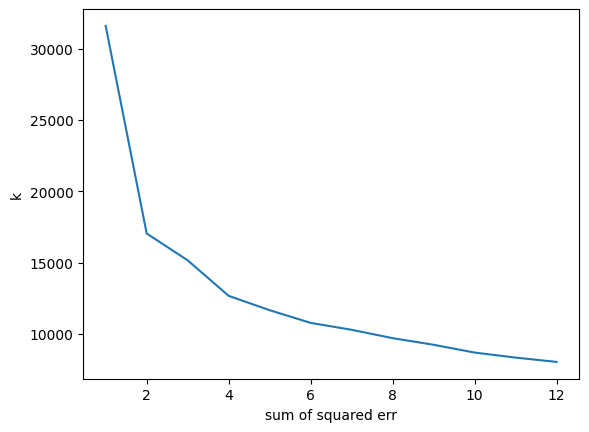

In [63]:
plt.plot(k_range,sse)
plt.ylabel('sum of squared err')
plt.xlabel('k')

In [64]:
clusterer = KMeans(n_clusters=5)
y_predicted = clusterer.fit_predict(df[df.columns.values])
df['class'] = y_predicted

In [65]:
df.head()

,month,day,hour,bx_gsm,by_gsm,bz_gsm,bt,speed,density,temp,intensity,declination,inclination,north,east,vertical,horizontal,class
0,0.454545,0.233333,0.043478,0.898487,0.142555,0.229877,0.422429,0.311464,0.080716,0.079451,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0
1,0.454545,0.233333,0.086957,0.875788,0.072862,0.193724,0.431235,0.311464,0.080716,0.079451,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0
2,0.454545,0.233333,0.130435,0.790038,0.139388,0.212824,0.408443,0.311464,0.080716,0.079451,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0
3,0.454545,0.233333,0.173913,0.821564,0.084477,0.181446,0.430458,0.311464,0.080716,0.079451,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0
4,0.454545,0.233333,0.217391,0.793506,0.135164,0.122783,0.520332,0.311464,0.080716,0.079451,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0


In [66]:
# check distribution
df['class'].value_counts()

class
2    8807
4    8758
3    8710
0    4966
1    4270
Name: count, dtype: int64

In [67]:
grouped = df.groupby('class')

result = grouped.agg({'bx_gsm': ['mean', 'median'], 'by_gsm': ['mean', 'median'],
                       'bz_gsm': ['mean', 'median'], 'bt': ['mean', 'median'],
                       'vertical':['mean','median']})
# Rename the columns for clarity
result.columns = ['bx_mean', 'bx_median', 'by_mean',
                   'by_median', 'bz_mean', 'bz_median',
                     'bt_mean', 'bt_median','vt_mean','vt_median']
# Reset the index to make 'class'
result.reset_index(inplace=True)


In [68]:
print(result)

   class   bx_mean  bx_median   by_mean  by_median   bz_mean  bz_median  \
0      0  0.514977   0.508039  0.046683   0.035903  0.082538   0.072249   
1      1  0.581171   0.584332  0.039458   0.030623  0.062405   0.054570   
2      2  0.526428   0.516709  0.044995   0.032735  0.072911   0.060027   
3      3  0.552313   0.549180  0.044704   0.032735  0.078169   0.065484   
4      4  0.549551   0.551860  0.044166   0.033791  0.064662   0.051160   

    bt_mean  bt_median   vt_mean  vt_median  
0  0.154310   0.130536  0.059994   0.054054  
1  0.109862   0.103082  0.945110   0.932432  
2  0.127582   0.111111  0.478775   0.513514  
3  0.138304   0.121471  0.283528   0.270270  
4  0.107419   0.094794  0.759607   0.770270  


In [69]:
result['sum_of_medians'] = result['bx_median'] + result['by_median'] + \
    result['bz_median'] + result['bt_median'] + result['vt_median']

# Group by 'class' and calculate the sum
sum_of_medians = result.groupby('class')['sum_of_medians'].sum().reset_index()

sum_of_medians

,class,sum_of_medians
0,0,0.800781
1,1,1.705039
2,2,1.234096
3,3,1.039141
4,4,1.501875


In [70]:

df.to_csv('severity-classified-scaled.csv',index=False)

In [71]:
# Save the KMeans model to a .pkl file using pickle
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(clusterer, f)

In [72]:
# Properties of the scaler
print("Scaler Properties:")
print(f"Feature Range: {scaler.feature_range}")
print(f"Data Min: {scaler.data_min_}")
print(f"Data Max: {scaler.data_max_}")
print(f"Data Range: {scaler.data_range_}")

# Properties of the KMeans model
print("\nKMeans Model Properties:")
print(f"Number of clusters: {clusterer.n_clusters}")
print(f"Cluster Centers: \n{clusterer.cluster_centers_}")
print(f"Inertia: {clusterer.inertia_}")
print(f"Labels: {clusterer.labels_[:10]}")  # Displaying only the first 10 labels for brevity

Scaler Properties:
Feature Range: (0, 1)
Data Min: [ 1.0000e+00  1.0000e+00  0.0000e+00 -1.7330e+01  0.0000e+00  0.0000e+00
  4.9000e-01  2.5930e+02  6.3300e-01  4.4980e+03  5.7265e+04  7.4086e+01
  8.9711e+01  7.0000e+00  2.6000e+01  5.7264e+04  2.7000e+01]
Data Max: [1.200000e+01 3.100000e+01 2.300000e+01 1.439000e+01 9.470000e+00
 1.466000e+01 3.910000e+01 8.117000e+02 7.835300e+01 1.338443e+06
 5.733800e+04 8.537300e+01 8.997300e+01 2.300000e+01 2.880000e+02
 5.733800e+04 2.890000e+02]
Data Range: [1.100000e+01 3.000000e+01 2.300000e+01 3.172000e+01 9.470000e+00
 1.466000e+01 3.861000e+01 5.524000e+02 7.772000e+01 1.333945e+06
 7.300000e+01 1.128700e+01 2.620000e-01 1.600000e+01 2.620000e+02
 7.400000e+01 2.620000e+02]

KMeans Model Properties:
Number of clusters: 5
Cluster Centers: 
[[0.73693845 0.50623574 0.5        0.51497658 0.04668255 0.08253768
  0.15431028 0.31146356 0.0807155  0.07945146 0.05466211 0.9939198
  0.05983282 0.95381091 0.93959536 0.05999445 0.93902353]
 [0.2242

In [2]:
# Define the mapping dictionary
mapping = {0: 0, 3: 1, 2: 2, 4: 3, 1: 4}

# Function to apply the mapping
def map_value(value):
    return mapping.get(value, -1)  # Returns -1 if the value is not in the mapping

# Example usage
mapped_values = [map_value(v) for v in [0, 3, 2, 4, 1, 5]]
print(mapped_values)


[0, 1, 2, 3, 4, -1]
